In [1]:
!pip3 install tqdm

In [2]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim

from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import mean_absolute_error, cohen_kappa_score, accuracy_score, mean_squared_error

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

<h1>Data Augmentation</h1>

In [4]:
data_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

<h1>Load dataset and Visualize Images</h1>

In [5]:
data_dir = '/kaggle/input/ordinal-classification-uc/ordinal_classification_UC/'
train_data = datasets.ImageFolder(root=os.path.join(data_dir,'train'), transform=data_augmentation)
valid_data = datasets.ImageFolder(root=os.path.join(data_dir,'valid'), transform=transform)
test_data = datasets.ImageFolder(root=os.path.join(data_dir,'test'), transform=transform)

In [6]:
ordinal_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
ordinal_dataloader_iter = iter(ordinal_dataloader)
images, labels = next(ordinal_dataloader_iter)

In [7]:
def imshow(axe,img):
    npimg = img.numpy()
    axe.imshow(np.transpose(npimg, (1, 2, 0)))
    axe.axis('off')

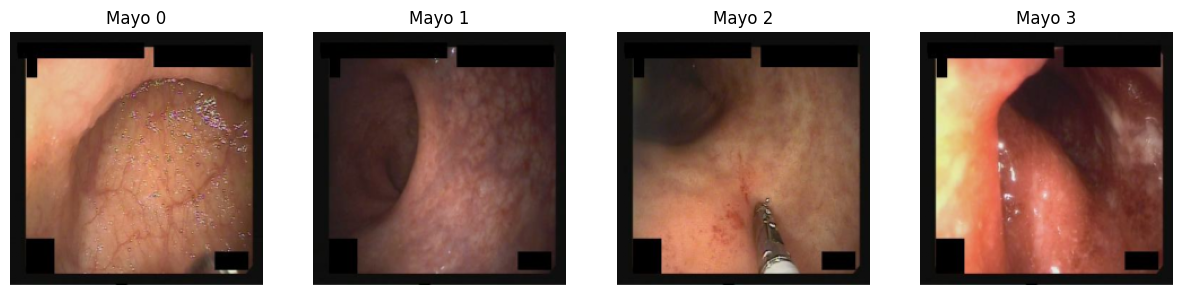

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15)) 
class_names = train_data.classes
count = 0
previous_label = []
for img, label in zip(images, labels):
    if count == 0:
        previous_label.append(class_names[label])
        axes[0].set_title(class_names[label])
        imshow(axes[0],img)
        count += 1
    elif class_names[label] not in previous_label:
        previous_label.append(class_names[label])
        axes[count].set_title(class_names[label])
        imshow(axes[count],img)
        count += 1

    if count > 3: break
plt.show()    

<h1>Ordinal Classification</h1>

In [7]:
def create_binary_labels_torch(aOrdinalLabels, aNumClasses=4):
    num_samples = len(aOrdinalLabels)
    binary_labels = []
    for k in range(0, aNumClasses - 1):
        labels_k = torch.zeros(num_samples, dtype=torch.float32)
        labels_k[aOrdinalLabels >= k] = 1.0
        binary_labels.append(labels_k.unsqueeze(1))
    return torch.cat(binary_labels, dim=1)

In [8]:
def predict_ordinal_torch(aProbabilities, aThreshold=0.5):
    num_binary_tasks = aProbabilities.size(1)
    predicted_ordinal = []
    for probs in aProbabilities:
        predicted_class = 0
        for i in range(num_binary_tasks):
            if probs[i] < aThreshold:
                predicted_class = i
                break
            elif i == num_binary_tasks - 1:
                predicted_class = num_binary_tasks
        predicted_ordinal.append(predicted_class)
    return torch.tensor(predicted_ordinal)

In [9]:
class OrdinalDataset(Dataset):
    def __init__(self, aImages, aBinaryLabels):
        self.images = aImages
        self.binary_labels = aBinaryLabels

    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        img = self.images[idx]
        image = img
        labels = self.binary_labels[idx]
        
        return image, labels

In [10]:
class OrdinalClassifier(nn.Module):
    def __init__(self, aNumOrdinalClasses=4):
        super(OrdinalClassifier, self).__init__()

        self.backbone = models.resnet50(weights='DEFAULT')
        feature_dim = self.backbone.fc.in_features 
        self.backbone.fc = nn.Identity()
 
        self.ordinal_head = nn.Linear(feature_dim, aNumOrdinalClasses - 1)

    def forward(self, x):
        features = self.backbone(x)
        ordinal_output = torch.sigmoid(self.ordinal_head(features))
        return ordinal_output

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [11]:
# Defining model, Loss function, and Optimizer
model = OrdinalClassifier()
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

early_stopping = EarlyStopping(patience=5, delta=0.01)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s] 


In [12]:
binary_train_labels = create_binary_labels_torch(labels)
train_dataset = OrdinalDataset(images, binary_train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)


valid_images, valid_labels = next(iter(DataLoader(valid_data, batch_size=32, shuffle=True)))
binary_valid_labels = create_binary_labels_torch(valid_labels)
valid_dataset = OrdinalDataset(valid_images, binary_valid_labels)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)


test_images, test_labels = next(iter(DataLoader(test_data, batch_size=32, shuffle=True)))
binary_test_labels = create_binary_labels_torch(test_labels)
test_dataset = OrdinalDataset(test_images, binary_test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [13]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, ordinal_labels in tqdm(train_dataloader, desc='Train: '):
        images, ordinal_labels = images.to(device), ordinal_labels.to(device)


        optimizer.zero_grad()
        ordinal_pred = model(images)
        loss = criterion(ordinal_pred, ordinal_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for valid_images, valid_ordinal_labels in tqdm(valid_dataloader, desc='validate: '):
            valid_images, valid_ordinal_labels = valid_images.to(device), valid_ordinal_labels.to(device)
    
            valid_ordinal_pred = model(valid_images)
            validation_loss = criterion(valid_ordinal_pred, valid_ordinal_labels)
    
            valid_loss = validation_loss.item() * valid_images.size(0)

    

    print(f"Epoch {epoch+1}/{num_epochs}: Train_Loss: {train_loss / len(train_dataloader)}\tValid_Loss: {valid_loss / len(valid_dataloader)}")

    if early_stopping.early_stop
        


validate: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


Epoch 1/100: Train_Loss: 22.160476684570312	Valid_Loss: 16.574071884155273


validate: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


Epoch 2/100: Train_Loss: 14.609454154968262	Valid_Loss: 12.572029113769531


validate: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


Epoch 3/100: Train_Loss: 8.957895278930664	Valid_Loss: 10.857032775878906


validate: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


Epoch 4/100: Train_Loss: 4.084535121917725	Valid_Loss: 11.654800415039062


validate: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


Epoch 5/100: Train_Loss: 1.5851668119430542	Valid_Loss: 16.01060676574707


validate: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


Epoch 6/100: Train_Loss: 0.5637773871421814	Valid_Loss: 22.959035873413086


validate: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


Epoch 7/100: Train_Loss: 0.21648381650447845	Valid_Loss: 31.288223266601562


validate: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


Epoch 8/100: Train_Loss: 0.09201221168041229	Valid_Loss: 39.51104736328125


validate: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


Epoch 9/100: Train_Loss: 0.04516207426786423	Valid_Loss: 45.696617126464844


validate: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


Epoch 10/100: Train_Loss: 0.024991389364004135	Valid_Loss: 49.513031005859375


validate: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


Epoch 11/100: Train_Loss: 0.015154339373111725	Valid_Loss: 50.76286315917969


validate: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


Epoch 12/100: Train_Loss: 0.00986458919942379	Valid_Loss: 50.33013153076172


validate: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


Epoch 13/100: Train_Loss: 0.006795355584472418	Valid_Loss: 48.843360900878906


validate: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


Epoch 14/100: Train_Loss: 0.004897615406662226	Valid_Loss: 46.884796142578125


validate: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


Epoch 15/100: Train_Loss: 0.003654750995337963	Valid_Loss: 45.3392448425293


validate: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


Epoch 16/100: Train_Loss: 0.0028066360391676426	Valid_Loss: 44.182613372802734


validate: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


Epoch 17/100: Train_Loss: 0.0022065923549234867	Valid_Loss: 43.35266876220703


validate: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


Epoch 18/100: Train_Loss: 0.0017719371244311333	Valid_Loss: 42.233062744140625


validate: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


Epoch 19/100: Train_Loss: 0.0014490443281829357	Valid_Loss: 68.697021484375


validate: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


Epoch 20/100: Train_Loss: 0.0012039884459227324	Valid_Loss: 66.77254486083984


validate: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


Epoch 21/100: Train_Loss: 0.0010145546402782202	Valid_Loss: 36.90461349487305


validate: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


Epoch 22/100: Train_Loss: 0.0008666105568408966	Valid_Loss: 35.107696533203125


validate: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


Epoch 23/100: Train_Loss: 0.0007490452262572944	Valid_Loss: 33.76676559448242


validate: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


Epoch 24/100: Train_Loss: 0.0006546377553604543	Valid_Loss: 32.5943603515625


validate: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


Epoch 25/100: Train_Loss: 0.0005779722705483437	Valid_Loss: 32.03220748901367


validate: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


Epoch 26/100: Train_Loss: 0.00051466393051669	Valid_Loss: 31.55280113220215


validate: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


Epoch 27/100: Train_Loss: 0.00046250229934230447	Valid_Loss: 31.09589195251465


validate: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


Epoch 28/100: Train_Loss: 0.0004193187633063644	Valid_Loss: 30.620162963867188


validate: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


Epoch 29/100: Train_Loss: 0.00038316816790029407	Valid_Loss: 30.08120346069336


validate: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


Epoch 30/100: Train_Loss: 0.0003524382773321122	Valid_Loss: 29.61185073852539


validate: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


Epoch 31/100: Train_Loss: 0.00032620131969451904	Valid_Loss: 29.140193939208984


validate: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


Epoch 32/100: Train_Loss: 0.0003035907866433263	Valid_Loss: 28.653343200683594


validate: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


Epoch 33/100: Train_Loss: 0.0002842205576598644	Valid_Loss: 28.128753662109375


validate: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


Epoch 34/100: Train_Loss: 0.0002674270945135504	Valid_Loss: 27.607620239257812


validate: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


Epoch 35/100: Train_Loss: 0.0002526816679164767	Valid_Loss: 27.06893539428711


validate: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


Epoch 36/100: Train_Loss: 0.00023978858371265233	Valid_Loss: 26.546836853027344


validate: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


Epoch 37/100: Train_Loss: 0.0002283139619976282	Valid_Loss: 26.022659301757812


validate: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


Epoch 38/100: Train_Loss: 0.00021813350031152368	Valid_Loss: 25.494461059570312


validate: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


Epoch 39/100: Train_Loss: 0.00020913963089697063	Valid_Loss: 25.007957458496094


validate: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


Epoch 40/100: Train_Loss: 0.0002006845170399174	Valid_Loss: 24.54229736328125


validate: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


Epoch 41/100: Train_Loss: 0.00019329646602272987	Valid_Loss: 24.108627319335938


validate: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


Epoch 42/100: Train_Loss: 0.00018662834190763533	Valid_Loss: 23.697860717773438


validate: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


Epoch 43/100: Train_Loss: 0.00018071368685923517	Valid_Loss: 23.31562042236328


validate: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


Epoch 44/100: Train_Loss: 0.00017507471784483641	Valid_Loss: 22.966896057128906


validate: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


Epoch 45/100: Train_Loss: 0.00017007596034090966	Valid_Loss: 22.639850616455078


validate: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


Epoch 46/100: Train_Loss: 0.00016540537762921304	Valid_Loss: 22.32862091064453


validate: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


Epoch 47/100: Train_Loss: 0.0001610367908142507	Valid_Loss: 22.042556762695312


validate: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


Epoch 48/100: Train_Loss: 0.0001571491447975859	Valid_Loss: 21.783496856689453


validate: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


Epoch 49/100: Train_Loss: 0.00015360397810582072	Valid_Loss: 21.545116424560547


validate: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


Epoch 50/100: Train_Loss: 0.0001504232204752043	Valid_Loss: 21.32449722290039


validate: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


Epoch 51/100: Train_Loss: 0.00014727431698702276	Valid_Loss: 21.124237060546875


validate: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


Epoch 52/100: Train_Loss: 0.00014458145597018301	Valid_Loss: 20.941532135009766


validate: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


Epoch 53/100: Train_Loss: 0.00014201544399838895	Valid_Loss: 20.773845672607422


validate: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


Epoch 54/100: Train_Loss: 0.00013948768901173025	Valid_Loss: 20.61992645263672


validate: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


Epoch 55/100: Train_Loss: 0.00013746511831413954	Valid_Loss: 20.480661392211914


validate: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


Epoch 56/100: Train_Loss: 0.00013518580817617476	Valid_Loss: 20.353240966796875


validate: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


Epoch 57/100: Train_Loss: 0.0001333191030425951	Valid_Loss: 20.235464096069336


validate: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


Epoch 58/100: Train_Loss: 0.0001313817483605817	Valid_Loss: 20.125797271728516


validate: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


Epoch 59/100: Train_Loss: 0.0001298458082601428	Valid_Loss: 20.024036407470703


validate: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


Epoch 60/100: Train_Loss: 0.00012838895781897008	Valid_Loss: 19.931385040283203


validate: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


Epoch 61/100: Train_Loss: 0.00012676908227149397	Valid_Loss: 19.846492767333984


validate: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


Epoch 62/100: Train_Loss: 0.00012522107863333076	Valid_Loss: 19.7684326171875


validate: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


Epoch 63/100: Train_Loss: 0.0001238211989402771	Valid_Loss: 19.697269439697266


validate: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


Epoch 64/100: Train_Loss: 0.00012260644871275872	Valid_Loss: 19.63243293762207


validate: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


Epoch 65/100: Train_Loss: 0.00012137606972828507	Valid_Loss: 19.57302474975586


validate: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


Epoch 66/100: Train_Loss: 0.00012020792200928554	Valid_Loss: 19.518630981445312


validate: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


Epoch 67/100: Train_Loss: 0.00011906043800991029	Valid_Loss: 19.468549728393555


validate: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


Epoch 68/100: Train_Loss: 0.00011824961984530091	Valid_Loss: 19.422588348388672


validate: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


Epoch 69/100: Train_Loss: 0.00011713866842910647	Valid_Loss: 19.380691528320312


validate: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


Epoch 70/100: Train_Loss: 0.00011624266335275024	Valid_Loss: 19.342098236083984


validate: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


Epoch 71/100: Train_Loss: 0.00011536150122992694	Valid_Loss: 19.306926727294922


validate: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


Epoch 72/100: Train_Loss: 0.0001145737332990393	Valid_Loss: 19.27472496032715


validate: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


Epoch 73/100: Train_Loss: 0.00011379931675037369	Valid_Loss: 19.24543571472168


validate: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


Epoch 74/100: Train_Loss: 0.00011307727254461497	Valid_Loss: 19.21844482421875


validate: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


Epoch 75/100: Train_Loss: 0.00011216830171179026	Valid_Loss: 19.193801879882812


validate: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


Epoch 76/100: Train_Loss: 0.00011134955275338143	Valid_Loss: 19.17125701904297


validate: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


Epoch 77/100: Train_Loss: 0.00011077942326664925	Valid_Loss: 19.150888442993164


validate: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


Epoch 78/100: Train_Loss: 0.0001100600347854197	Valid_Loss: 19.13226318359375


validate: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


Epoch 79/100: Train_Loss: 0.00010946911061182618	Valid_Loss: 19.115337371826172


validate: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


Epoch 80/100: Train_Loss: 0.0001088074641302228	Valid_Loss: 19.099889755249023


validate: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


Epoch 81/100: Train_Loss: 0.00010807465150719509	Valid_Loss: 19.085895538330078


validate: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


Epoch 82/100: Train_Loss: 0.00010738921992015094	Valid_Loss: 19.073246002197266


validate: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


Epoch 83/100: Train_Loss: 0.00010679047409212217	Valid_Loss: 19.061683654785156


validate: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


Epoch 84/100: Train_Loss: 0.00010627850861055776	Valid_Loss: 19.05120849609375


validate: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


Epoch 85/100: Train_Loss: 0.00010553468018770218	Valid_Loss: 19.04189682006836


validate: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


Epoch 86/100: Train_Loss: 0.00010491659486433491	Valid_Loss: 19.033432006835938


validate: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Epoch 87/100: Train_Loss: 0.00010434433352202177	Valid_Loss: 19.025882720947266


validate: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


Epoch 88/100: Train_Loss: 0.00010373834811616689	Valid_Loss: 19.019142150878906


validate: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


Epoch 89/100: Train_Loss: 0.00010325738548999652	Valid_Loss: 19.013153076171875


validate: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


Epoch 90/100: Train_Loss: 0.0001028616024996154	Valid_Loss: 19.00783920288086


validate: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Epoch 91/100: Train_Loss: 0.00010227271559415385	Valid_Loss: 19.003232955932617


validate: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


Epoch 92/100: Train_Loss: 0.00010192749323323369	Valid_Loss: 18.999095916748047


validate: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


Epoch 93/100: Train_Loss: 0.00010126945562660694	Valid_Loss: 18.99556541442871


validate: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


Epoch 94/100: Train_Loss: 0.00010081495565827936	Valid_Loss: 18.992427825927734


validate: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


Epoch 95/100: Train_Loss: 0.00010024601215263829	Valid_Loss: 18.989852905273438


validate: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


Epoch 96/100: Train_Loss: 9.988009696826339e-05	Valid_Loss: 18.98762321472168


validate: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


Epoch 97/100: Train_Loss: 9.935954585671425e-05	Valid_Loss: 18.985797882080078


validate: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


Epoch 98/100: Train_Loss: 9.904179023578763e-05	Valid_Loss: 18.98435401916504


validate: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


Epoch 99/100: Train_Loss: 9.848973422776908e-05	Valid_Loss: 18.983287811279297


validate: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]

Epoch 100/100: Train_Loss: 9.802101703826338e-05	Valid_Loss: 18.982463836669922


In [14]:
model.eval()
all_predicted_ordinal = []
all_true_ordinal = []
all_predicted_binary_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_dataloader, desc='Test: '):
        test_images = images.to(device)
        outputs = model(test_images)
        predicted_ordinal_batch = predict_ordinal_torch(outputs.cpu(), 0.5)
        all_predicted_ordinal.extend(predicted_ordinal_batch.numpy())
        all_true_ordinal.extend(test_labels)
        all_predicted_binary_probs.extend(outputs.cpu().numpy())

all_predicted_ordinal = np.array(all_predicted_ordinal)
all_true_ordinal = np.array(all_true_ordinal)
all_predicted_binary_probs = np.array(all_predicted_binary_probs)

Test: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


In [18]:
mae = mean_absolute_error(all_true_ordinal, all_predicted_ordinal)
mse = mean_squared_error(all_true_ordinal, all_predicted_ordinal)
kappa = cohen_kappa_score(all_true_ordinal, all_predicted_ordinal, weights='quadratic')

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

Mean Absolute Error: 1.2188
Mean Squared Error: 2.1562
Cohen's Kappa: 0.0247


<h1>Ordinal classification + Fine-Grained</h1>

In [9]:
class OrdinalFineGrainedDataset(Dataset):
    def __init__(self, aImages, aBinaryLabels, aOrdinalClasses):
        self.images = aImages
        self.binary_labels = aBinaryLabels
        self.ordinal_classes = aOrdinalClasses

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        image = img
        labels = self.binary_labels[idx]
        fine_class = self.ordinal_classes[idx]

        return img, fine_class, labels

In [10]:
class OrdinalFineGrainedNet(nn.Module):
    def __init__(self, aNumClasses=4, aNumOrdinaLevels=4):
        super(OrdinalFineGrainedNet, self).__init__()

        self.backbone = models.resnet50(weights='DEFAULT')
        feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.fine_class_head = nn.Linear(feature_dim, aNumClasses)
        self.ordinal_head = nn.Linear(feature_dim, aNumOrdinaLevels - 1)

    def forward(self, x):
        features = self.backbone(x)

        fine_out = torch.softmax(self.fine_class_head(features), dim=1)
        ordinal_out = torch.sigmoid(self.ordinal_head(features))

        return fine_out, ordinal_out

In [11]:
class OrdinalFineGrainedLoss(nn.Module):
    def __init__(self, aAlpha=1.0, aBeta=1.0):
        super().__init__()
        self.alpha = aAlpha  # Weight for ordinal loss
        self.beta = aBeta  # Weight for fine-grained loss
        self.class_loss = nn.CrossEntropyLoss()
        self.ordinal_loss = nn.BCELoss()  # Binary cross-entropy for ordinal labels

    def forward(self, fine_pred, fine_target, ordinal_pred, ordinal_target):
        loss_fine = self.class_loss(fine_pred, fine_target)  # Fine classification loss
        loss_ordinal = self.ordinal_loss(ordinal_pred, ordinal_target)  # Ordinal loss
        return self.alpha * loss_fine + self.beta * loss_ordinal

In [12]:
# Defining model, Loss function, and Optimizer
model = OrdinalFineGrainedNet()
model.to(device)
criterion = OrdinalFineGrainedLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# early_stopping = EarlyStopping(patience=5, delta=0.01)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s] 


In [13]:
binary_train_labels = create_binary_labels_torch(labels)
train_dataset = OrdinalFineGrainedDataset(images, binary_train_labels, labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)


valid_images, valid_labels = next(iter(DataLoader(valid_data, batch_size=32, shuffle=True)))
binary_valid_labels = create_binary_labels_torch(valid_labels)
valid_dataset = OrdinalFineGrainedDataset(valid_images, binary_valid_labels, valid_labels)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)


test_images, test_labels = next(iter(DataLoader(test_data, batch_size=32, shuffle=True)))
binary_test_labels = create_binary_labels_torch(test_labels)
test_dataset = OrdinalFineGrainedDataset(test_images, binary_test_labels, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [14]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, fine_labels, ordinal_labels in tqdm(train_dataloader, desc='Train: '):
        images, fine_labels, ordinal_labels = images.to(device), fine_labels.to(device), ordinal_labels.to(device)
        
        optimizer.zero_grad()
        fine_pred, ordinal_pred = model(images)
        loss = criterion(fine_pred, fine_labels, ordinal_pred, ordinal_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for valid_images, valid_fine_labels, valid_ordinal_labels in tqdm(valid_dataloader, desc='validate: '):
            valid_images, valid_fine_labels, valid_ordinal_labels = valid_images.to(device), valid_fine_labels.to(device), valid_ordinal_labels.to(device)
    
            valid_fine_pred, valid_ordinal_pred = model(valid_images)
            validation_loss = criterion(valid_fine_pred, valid_fine_labels, valid_ordinal_pred, valid_ordinal_labels)
    
            valid_loss = validation_loss.item() * valid_images.size(0)


    print(f"Epoch {epoch+1}/{num_epochs}: Train_Loss: {train_loss / len(train_dataloader)}\tValid_Loss: {valid_loss / len(valid_dataloader)}")

validate: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


Epoch 1/100: Train_Loss: 66.56605529785156	Valid_Loss: 59.89118576049805


validate: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


Epoch 2/100: Train_Loss: 56.863800048828125	Valid_Loss: 51.54304885864258


validate: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


Epoch 3/100: Train_Loss: 45.86434555053711	Valid_Loss: 46.36854934692383


validate: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


Epoch 4/100: Train_Loss: 35.09014129638672	Valid_Loss: 45.01533889770508


validate: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


Epoch 5/100: Train_Loss: 29.532047271728516	Valid_Loss: 46.00228500366211


validate: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


Epoch 6/100: Train_Loss: 26.482385635375977	Valid_Loss: 50.73987579345703


validate: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


Epoch 7/100: Train_Loss: 24.945377349853516	Valid_Loss: 56.36407470703125


validate: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


Epoch 8/100: Train_Loss: 24.20166778564453	Valid_Loss: 61.76305389404297


validate: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


Epoch 9/100: Train_Loss: 23.9637393951416	Valid_Loss: 67.25942993164062


validate: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


Epoch 10/100: Train_Loss: 23.88003921508789	Valid_Loss: 71.40203857421875


validate: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


Epoch 11/100: Train_Loss: 23.845224380493164	Valid_Loss: 74.75909423828125


validate: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


Epoch 12/100: Train_Loss: 23.8278751373291	Valid_Loss: 77.43701171875


validate: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


Epoch 13/100: Train_Loss: 23.817981719970703	Valid_Loss: 79.67510223388672


validate: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


Epoch 14/100: Train_Loss: 23.81183624267578	Valid_Loss: 81.51016235351562


validate: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


Epoch 15/100: Train_Loss: 23.80784797668457	Valid_Loss: 82.70402526855469


validate: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


Epoch 16/100: Train_Loss: 23.8051815032959	Valid_Loss: 83.33192443847656


validate: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


Epoch 17/100: Train_Loss: 23.803359985351562	Valid_Loss: 83.48538208007812


validate: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


Epoch 18/100: Train_Loss: 23.80206871032715	Valid_Loss: 82.93624114990234


validate: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


Epoch 19/100: Train_Loss: 23.8011417388916	Valid_Loss: 81.9617919921875


validate: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


Epoch 20/100: Train_Loss: 23.800460815429688	Valid_Loss: 80.6695785522461


validate: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


Epoch 21/100: Train_Loss: 23.799943923950195	Valid_Loss: 79.1213607788086


validate: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


Epoch 22/100: Train_Loss: 23.7995548248291	Valid_Loss: 77.48670959472656


validate: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


Epoch 23/100: Train_Loss: 23.799251556396484	Valid_Loss: 75.76203918457031


validate: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


Epoch 24/100: Train_Loss: 23.79900360107422	Valid_Loss: 74.1042251586914


validate: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


Epoch 25/100: Train_Loss: 23.798810958862305	Valid_Loss: 72.44586181640625


validate: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


Epoch 26/100: Train_Loss: 23.79865264892578	Valid_Loss: 70.81358337402344


validate: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


Epoch 27/100: Train_Loss: 23.79851722717285	Valid_Loss: 69.21910095214844


validate: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


Epoch 28/100: Train_Loss: 23.79840660095215	Valid_Loss: 67.70972442626953


validate: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


Epoch 29/100: Train_Loss: 23.798309326171875	Valid_Loss: 66.27778625488281


validate: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


Epoch 30/100: Train_Loss: 23.798233032226562	Valid_Loss: 64.89065551757812


validate: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


Epoch 31/100: Train_Loss: 23.79816436767578	Valid_Loss: 63.57247543334961


validate: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


Epoch 32/100: Train_Loss: 23.798107147216797	Valid_Loss: 62.349029541015625


validate: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


Epoch 33/100: Train_Loss: 23.79805564880371	Valid_Loss: 61.25695037841797


validate: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


Epoch 34/100: Train_Loss: 23.79801368713379	Valid_Loss: 60.26021957397461


validate: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


Epoch 35/100: Train_Loss: 23.7979736328125	Valid_Loss: 59.34779357910156


validate: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


Epoch 36/100: Train_Loss: 23.79794692993164	Valid_Loss: 58.517333984375


validate: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


Epoch 37/100: Train_Loss: 23.797916412353516	Valid_Loss: 57.754486083984375


validate: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


Epoch 38/100: Train_Loss: 23.79789161682129	Valid_Loss: 57.05878829956055


validate: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


Epoch 39/100: Train_Loss: 23.797866821289062	Valid_Loss: 56.42145919799805


validate: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


Epoch 40/100: Train_Loss: 23.797842025756836	Valid_Loss: 55.84103012084961


validate: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


Epoch 41/100: Train_Loss: 23.79783058166504	Valid_Loss: 55.31095886230469


validate: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


Epoch 42/100: Train_Loss: 23.797815322875977	Valid_Loss: 54.826332092285156


validate: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


Epoch 43/100: Train_Loss: 23.79779624938965	Valid_Loss: 54.39088439941406


validate: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


Epoch 44/100: Train_Loss: 23.79778289794922	Valid_Loss: 53.99686050415039


validate: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


Epoch 45/100: Train_Loss: 23.797775268554688	Valid_Loss: 53.63786315917969


validate: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


Epoch 46/100: Train_Loss: 23.797767639160156	Valid_Loss: 53.308258056640625


validate: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


Epoch 47/100: Train_Loss: 23.797754287719727	Valid_Loss: 53.005943298339844


validate: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


Epoch 48/100: Train_Loss: 23.797746658325195	Valid_Loss: 52.73375701904297


validate: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


Epoch 49/100: Train_Loss: 23.79773712158203	Valid_Loss: 52.48586654663086


validate: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


Epoch 50/100: Train_Loss: 23.7977294921875	Valid_Loss: 52.25924301147461


validate: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


Epoch 51/100: Train_Loss: 23.797725677490234	Valid_Loss: 52.053260803222656


validate: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


Epoch 52/100: Train_Loss: 23.797712326049805	Valid_Loss: 51.86526107788086


validate: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


Epoch 53/100: Train_Loss: 23.797710418701172	Valid_Loss: 51.69322967529297


validate: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


Epoch 54/100: Train_Loss: 23.797710418701172	Valid_Loss: 51.53575897216797


validate: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


Epoch 55/100: Train_Loss: 23.797700881958008	Valid_Loss: 51.39284133911133


validate: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


Epoch 56/100: Train_Loss: 23.797697067260742	Valid_Loss: 51.2623176574707


validate: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


Epoch 57/100: Train_Loss: 23.797693252563477	Valid_Loss: 51.14264678955078


validate: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


Epoch 58/100: Train_Loss: 23.79768943786621	Valid_Loss: 51.03289794921875


validate: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


Epoch 59/100: Train_Loss: 23.797687530517578	Valid_Loss: 50.932552337646484


validate: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


Epoch 60/100: Train_Loss: 23.797677993774414	Valid_Loss: 50.84103012084961


validate: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


Epoch 61/100: Train_Loss: 23.797672271728516	Valid_Loss: 50.757965087890625


validate: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


Epoch 62/100: Train_Loss: 23.79767417907715	Valid_Loss: 50.68172836303711


validate: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


Epoch 63/100: Train_Loss: 23.79767417907715	Valid_Loss: 50.6122932434082


validate: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


Epoch 64/100: Train_Loss: 23.79766845703125	Valid_Loss: 50.548892974853516


validate: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


Epoch 65/100: Train_Loss: 23.797666549682617	Valid_Loss: 50.49080276489258


validate: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


Epoch 66/100: Train_Loss: 23.797666549682617	Valid_Loss: 50.437591552734375


validate: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


Epoch 67/100: Train_Loss: 23.797658920288086	Valid_Loss: 50.388771057128906


validate: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


Epoch 68/100: Train_Loss: 23.79766273498535	Valid_Loss: 50.34394073486328


validate: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


Epoch 69/100: Train_Loss: 23.797651290893555	Valid_Loss: 50.30295944213867


validate: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


Epoch 70/100: Train_Loss: 23.797653198242188	Valid_Loss: 50.265472412109375


validate: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


Epoch 71/100: Train_Loss: 23.797653198242188	Valid_Loss: 50.231239318847656


validate: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


Epoch 72/100: Train_Loss: 23.797651290893555	Valid_Loss: 50.199859619140625


validate: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


Epoch 73/100: Train_Loss: 23.797645568847656	Valid_Loss: 50.171165466308594


validate: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


Epoch 74/100: Train_Loss: 23.797639846801758	Valid_Loss: 50.14479064941406


validate: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


Epoch 75/100: Train_Loss: 23.797643661499023	Valid_Loss: 50.120704650878906


validate: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


Epoch 76/100: Train_Loss: 23.797636032104492	Valid_Loss: 50.09860610961914


validate: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


Epoch 77/100: Train_Loss: 23.797639846801758	Valid_Loss: 50.07831573486328


validate: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


Epoch 78/100: Train_Loss: 23.797639846801758	Valid_Loss: 50.05970764160156


validate: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


Epoch 79/100: Train_Loss: 23.797630310058594	Valid_Loss: 50.04266357421875


validate: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


Epoch 80/100: Train_Loss: 23.797632217407227	Valid_Loss: 50.02705001831055


validate: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


Epoch 81/100: Train_Loss: 23.797632217407227	Valid_Loss: 50.012733459472656


validate: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


Epoch 82/100: Train_Loss: 23.79763412475586	Valid_Loss: 49.99962615966797


validate: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


Epoch 83/100: Train_Loss: 23.79762840270996	Valid_Loss: 49.98761749267578


validate: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


Epoch 84/100: Train_Loss: 23.79762840270996	Valid_Loss: 49.97660827636719


validate: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


Epoch 85/100: Train_Loss: 23.79762840270996	Valid_Loss: 49.96647644042969


validate: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


Epoch 86/100: Train_Loss: 23.797622680664062	Valid_Loss: 49.95721435546875


validate: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


Epoch 87/100: Train_Loss: 23.797624588012695	Valid_Loss: 49.94868469238281


validate: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


Epoch 88/100: Train_Loss: 23.797622680664062	Valid_Loss: 49.94085693359375


validate: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


Epoch 89/100: Train_Loss: 23.79761505126953	Valid_Loss: 49.93365478515625


validate: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


Epoch 90/100: Train_Loss: 23.797611236572266	Valid_Loss: 49.927032470703125


validate: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


Epoch 91/100: Train_Loss: 23.79762077331543	Valid_Loss: 49.92095184326172


validate: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


Epoch 92/100: Train_Loss: 23.7976131439209	Valid_Loss: 49.91534423828125


validate: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


Epoch 93/100: Train_Loss: 23.7976131439209	Valid_Loss: 49.91015625


validate: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


Epoch 94/100: Train_Loss: 23.797609329223633	Valid_Loss: 49.9053840637207


validate: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


Epoch 95/100: Train_Loss: 23.797607421875	Valid_Loss: 49.90098571777344


validate: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


Epoch 96/100: Train_Loss: 23.797609329223633	Valid_Loss: 49.896915435791016


validate: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


Epoch 97/100: Train_Loss: 23.797607421875	Valid_Loss: 49.89317321777344


validate: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


Epoch 98/100: Train_Loss: 23.797605514526367	Valid_Loss: 49.88972091674805


validate: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


Epoch 99/100: Train_Loss: 23.797605514526367	Valid_Loss: 49.886505126953125


validate: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]

Epoch 100/100: Train_Loss: 23.7976016998291	Valid_Loss: 49.88353729248047


In [15]:
model.eval()
all_predicted_ordinal = []
all_true_ordinal = []
all_predicted_binary_probs = []
all_predicted_fine_grained = []

with torch.no_grad():
    for test_images, test_fine_labels, test_ordinal_labels in tqdm(test_dataloader, desc='Test: '):
        test_images = test_images.to(device)
        predicted_fine_grained, predicted_ordinal = model(test_images)
        predicted_ordinal_batch = predict_ordinal_torch(predicted_ordinal.cpu(), 0.5)
        all_predicted_ordinal.extend(predicted_ordinal_batch.numpy())
        all_true_ordinal.extend(test_labels)
        all_predicted_binary_probs.extend(predicted_ordinal.cpu().numpy())
        all_predicted_fine_grained.extend(torch.argmax(predicted_fine_grained.cpu(), dim=1))

all_predicted_ordinal = np.array(all_predicted_ordinal)
all_true_ordinal = np.array(all_true_ordinal)
all_predicted_binary_probs = np.array(all_predicted_binary_probs)
all_predicted_fine_grained = np.array(all_predicted_fine_grained)

Test: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


In [16]:
accuracy = accuracy_score(all_true_ordinal, all_predicted_fine_grained)
mae = mean_absolute_error(all_true_ordinal, all_predicted_ordinal)
mse = mean_squared_error(all_true_ordinal, all_predicted_ordinal)
kappa = cohen_kappa_score(all_true_ordinal, all_predicted_ordinal, weights='quadratic')

print(f"Accuracy: {accuracy:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

Accuracy: 0.5000
Mean Absolute Error: 0.9062
Mean Squared Error: 1.0938
Cohen's Kappa: 0.0000
